In [1]:
from multivp_dataset import MULTI_VP_Dataset
from pathlib import Path
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

from sklearn.preprocessing import QuantileTransformer, MaxAbsScaler, RobustScaler, PowerTransformer, MinMaxScaler, StandardScaler
import numpy as np
from tqdm.notebook import tqdm

from models.mad_gan import Generator, Discriminator
from tools.viz import plot_anomalies, plot_single_var, plot_to_tensorboard
from tools.anomaly import reconstruction_anomaly_scores, madgan_reconstruction, madgan_reconstruction_discr_loss

class Options:
    def __init__(self):
        # Dataset
        self.data_path = Path('../data/compiled/inputs.csv')
        self.batch_size = 128
        self.nworkers = 4
        self.shuffle = True
        self.drop_last = False
        self.method = "window_mag"
        self.wsize = 10
        self.scaler = StandardScaler()
        
        # Train params
        self.lr = 0.0001
        self.epochs = 26
        self.G_niters = 15
        self.D_niters = 10
        
        self.model_out = Path('./runs/mad_gan/')
        self.train_plots = True

        # create ouput dirs
        if not self.model_out.exists(): self.model_out.mkdir(parents=True)
        
        (self.model_out / "img").mkdir(exist_ok=True)
        
opts = Options()
exp_num = 1

# Setup Dataset

In [2]:
dataset = MULTI_VP_Dataset(opts.data_path, method=opts.method, remove_extreme=True, scaler=opts.scaler, window_size=opts.wsize)
dataloader = DataLoader(dataset, batch_size=opts.batch_size, shuffle=opts.shuffle, 
                        num_workers=opts.nworkers, drop_last=opts.drop_last)

Removed 705 extreme values
Window size: 10
Window shape:  torch.Size([10, 640])
First window:
 tensor([[1.4774, 1.4774, 1.4775,  ..., 1.7887, 1.7887, 1.7887],
        [1.5262, 1.5262, 1.5261,  ..., 1.7887, 1.7887, 1.7887],
        [1.6488, 1.6487, 1.6486,  ..., 1.7888, 1.7888, 1.7887],
        ...,
        [1.5043, 1.5043, 1.5043,  ..., 1.7887, 1.7887, 1.7887],
        [1.5112, 1.5111, 1.5111,  ..., 1.7887, 1.7887, 1.7887],
        [1.6499, 1.6499, 1.6498,  ..., 1.7887, 1.7887, 1.7887]])
Inputs shape: (11066, 640)
Inputs head:
 [[1.47736421 1.47740931 1.47745443 ... 1.78869403 1.78869429 1.78869452]
 [1.52616798 1.52615489 1.52614156 ... 1.78874927 1.78874401 1.78873927]
 [1.6487677  1.64867649 1.64858473 ... 1.78875785 1.78875173 1.78874622]
 [1.44400983 1.44398607 1.44396218 ... 1.78877353 1.78876585 1.78875892]
 [1.60257507 1.60240941 1.60224318 ... 1.78875044 1.78874507 1.78874023]]


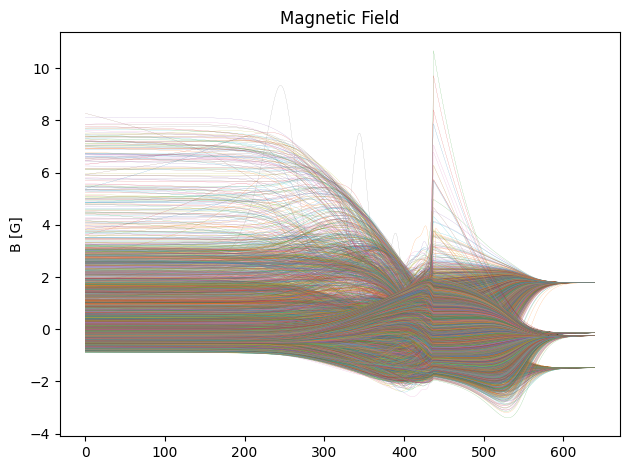

In [3]:
dataset.plot(title="Magnetic Field")

# Models

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device: ", device)

netG = Generator(
    input_size=dataset.inputs.shape[1],
    hidden_size=100,
    output_size=dataset.inputs.shape[1],
    nlayers=3,
    dropout=0,
    bidirectional=False,
    arch='GRU',
).to(device)

netD = Discriminator(
    input_size=dataset.inputs.shape[1],
    hidden_size=100,
    nlayers=1,
    dropout=0.1,
    bidirectional=False,
    arch='GRU',
).to(device)

Using device:  cuda:0


/home/ivsaav/.local/lib/python3.10/site-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [5]:
logger = SummaryWriter(f"logs/mad_gan_layers/e{exp_num}_D{netD.hidden_size}-L{netD.nlayers}_G{netG.hidden_size}-L{netG.nlayers}")
logger.add_graph(netG, torch.randn(opts.batch_size, opts.wsize, dataset.inputs.shape[1]).to(device))
logger.add_graph(netD, torch.randn(opts.batch_size, opts.wsize, dataset.inputs.shape[1]).to(device))
logger.add_text("Generator", netG.__str__())
logger.add_text("Discriminator", netD.__str__())

2023-03-09 18:28:40.337914: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
netG.train()

Generator(
  (rnn): GRU(640, 100, num_layers=3, batch_first=True)
  (linear): Linear(in_features=100, out_features=640, bias=True)
)

In [7]:
netD.train()

Discriminator(
  (rnn): GRU(640, 100, batch_first=True, dropout=0.1)
  (linear): Linear(in_features=100, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

# Training

In [8]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=opts.lr)
optimizerG = optim.Adam(netG.parameters(), lr=opts.lr)

In [9]:
# Training Loop

# Lists to keep track of progress
G_losses = []
D_losses = []
iters = 0
best_loss = np.inf
best_loss_dist = np.inf

print("Starting Training Loop...")
# For each epoch
for epoch in range(opts.epochs):
    D_epoch_loss = 0
    G_epoch_loss = 0
    
    # For each batch in the dataloader
    for i, (x, _filename) in tqdm(enumerate(dataloader, 0), leave=False, desc=f"Epoch [{epoch}/{opts.epochs}]", total=len(dataloader)):
        
        # Format batch
        real = x.to(device)
        b_size, seq_len = real.size(0), real.size(1)
        real_labels = torch.full((b_size, opts.wsize, 1), real_label, dtype=torch.float, device=device)
        
        # Train discriminator network to maximize log(D(x)) + log(1 - D(G(z)))
        for _ in range(opts.D_niters):
            netD.zero_grad()
            
            # Train with real batch
            output = netD(real)
            errD_real = criterion(output, real_labels)
            errD_real.backward()
            
            # Train with fake batch
            fake = netG(torch.randn_like(real, device=device))
            fake_labels = torch.full((b_size, opts.wsize, 1), fake_label, dtype=torch.float, device=device)
            
            output = netD(fake.detach())
            errD_fake = criterion(output, fake_labels)
            errD_fake.backward()
            
            errD = errD_real + errD_fake
            optimizerD.step()
        D_losses.append(errD.item())
        
        # Train generator network to maximize log(D(G(z)))
        for _ in range(opts.G_niters):
            netG.zero_grad()
            
            fake = netG(torch.randn_like(real, device=device))
            output = netD(fake)
            errG = criterion(output, real_labels)
            errG.backward()
            optimizerG.step()
        G_losses.append(errG.item())
        # send losses to tensorboard
        logger.add_scalars('Loss/train', {'G': errG.item(), 'D': errD.item()}, iters)
        iters += 1
        
    # Calculate epoch losses
    output = netD(real)
    errD_real = criterion(output, real_labels)
    D_x = output.mean().item()
    
    fake = netG(torch.randn_like(real, device=device)).detach()
    output = netD(fake)
    errD_fake = criterion(output, fake_labels)
    D_G_z1 = output.mean().item()
    
    errD = errD_real + errD_fake
    errG = criterion(output, real_labels)

    # Output training stats
    print('[%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f'
            % (epoch, opts.epochs,
                errD.item(), errG.item(), D_x, D_G_z1))

    # save best model if total loss is better than last 
    # and distance between losses is better than last (model convergence)
    if abs(errD-errG).item() < best_loss_dist and epoch > 2: 
        best_loss_dist = torch.abs(errD-errG).item()
        torch.save(netG.state_dict(), opts.model_out / 'Gbest.pth')
        torch.save(netD.state_dict(), opts.model_out / 'Dbest.pth')
        
        if opts.train_plots:
            fake = dataset.unscale(fake.detach().cpu().numpy())
            fig = plot_single_var(fake, 
                            title=f"Epoch {epoch} - G loss: {errG.item():.4f} - D loss: {errD.item():.4f} - Loss diff: {best_loss_dist:.4f}",
                            dpi=200, scale="log")
            plot_to_tensorboard(logger, fig, epoch, "train/best")
            plt.close(fig)
    elif epoch % 5 == 0:
        torch.save(netG.state_dict(), opts.model_out / f'G{epoch}.pth')
        torch.save(netD.state_dict(), opts.model_out / f'D{epoch}.pth')
        
        if opts.train_plots:
            fake = dataset.unscale(fake.detach().cpu().numpy())
            fig = plot_single_var(fake, 
                            title=f"Epoch {epoch} - G loss: {errG.item():.4f} - D loss: {errD.item():.4f} - Loss diff: {best_loss_dist:.4f}",
                            dpi=200, scale="log")
            # plt.savefig(opts.model_out / f'img/inter_{epoch}.png')
            plot_to_tensorboard(logger, fig, epoch, "train/inter")
            plt.close(fig)
    

Starting Training Loop...


Epoch [0/26]:   0%|          | 0/87 [00:00<?, ?it/s]

[0/26]	Loss_D: 0.0581	Loss_G: 3.6495	D(x): 0.9987	D(G(z)): 0.0537


Epoch [1/26]:   0%|          | 0/87 [00:00<?, ?it/s]

[1/26]	Loss_D: 0.0144	Loss_G: 4.5647	D(x): 0.9993	D(G(z)): 0.0136


Epoch [2/26]:   0%|          | 0/87 [00:00<?, ?it/s]

[2/26]	Loss_D: 0.0146	Loss_G: 4.4482	D(x): 0.9997	D(G(z)): 0.0141


Epoch [3/26]:   0%|          | 0/87 [00:00<?, ?it/s]

[3/26]	Loss_D: 1.3921	Loss_G: 1.5633	D(x): 0.9983	D(G(z)): 0.5701


Epoch [4/26]:   0%|          | 0/87 [00:00<?, ?it/s]

[4/26]	Loss_D: 0.0238	Loss_G: 4.0251	D(x): 0.9994	D(G(z)): 0.0228


Epoch [5/26]:   0%|          | 0/87 [00:00<?, ?it/s]

[5/26]	Loss_D: 0.2993	Loss_G: 2.2848	D(x): 0.9993	D(G(z)): 0.2409


Epoch [6/26]:   0%|          | 0/87 [00:00<?, ?it/s]

[6/26]	Loss_D: 0.0219	Loss_G: 4.2753	D(x): 0.9997	D(G(z)): 0.0211


Epoch [7/26]:   0%|          | 0/87 [00:00<?, ?it/s]

[7/26]	Loss_D: 0.0382	Loss_G: 4.3181	D(x): 0.9984	D(G(z)): 0.0353


Epoch [8/26]:   0%|          | 0/87 [00:00<?, ?it/s]

[8/26]	Loss_D: 0.0230	Loss_G: 4.6201	D(x): 0.9979	D(G(z)): 0.0202


Epoch [9/26]:   0%|          | 0/87 [00:00<?, ?it/s]

[9/26]	Loss_D: 0.0103	Loss_G: 7.8466	D(x): 0.9967	D(G(z)): 0.0060


Epoch [10/26]:   0%|          | 0/87 [00:00<?, ?it/s]

[10/26]	Loss_D: 4.3573	Loss_G: 0.7450	D(x): 0.9994	D(G(z)): 0.7504


Epoch [11/26]:   0%|          | 0/87 [00:00<?, ?it/s]

[11/26]	Loss_D: 0.1334	Loss_G: 2.6991	D(x): 0.9993	D(G(z)): 0.1125


Epoch [12/26]:   0%|          | 0/87 [00:00<?, ?it/s]

[12/26]	Loss_D: 0.3079	Loss_G: 1.6744	D(x): 0.9980	D(G(z)): 0.2460


Epoch [13/26]:   0%|          | 0/87 [00:00<?, ?it/s]

[13/26]	Loss_D: 0.0432	Loss_G: 3.4210	D(x): 0.9986	D(G(z)): 0.0400


Epoch [14/26]:   0%|          | 0/87 [00:00<?, ?it/s]

[14/26]	Loss_D: 0.0053	Loss_G: 8.4779	D(x): 0.9960	D(G(z)): 0.0005


Epoch [15/26]:   0%|          | 0/87 [00:00<?, ?it/s]

[15/26]	Loss_D: 0.0413	Loss_G: 3.3997	D(x): 0.9968	D(G(z)): 0.0369


Epoch [16/26]:   0%|          | 0/87 [00:00<?, ?it/s]

[16/26]	Loss_D: 0.0270	Loss_G: 4.5358	D(x): 0.9992	D(G(z)): 0.0257


Epoch [17/26]:   0%|          | 0/87 [00:00<?, ?it/s]

[17/26]	Loss_D: 0.0755	Loss_G: 3.1514	D(x): 0.9990	D(G(z)): 0.0707


Epoch [18/26]:   0%|          | 0/87 [00:00<?, ?it/s]

[18/26]	Loss_D: 0.0057	Loss_G: 6.5583	D(x): 0.9988	D(G(z)): 0.0044


Epoch [19/26]:   0%|          | 0/87 [00:00<?, ?it/s]

[19/26]	Loss_D: 0.1214	Loss_G: 3.5336	D(x): 0.9992	D(G(z)): 0.1067


Epoch [20/26]:   0%|          | 0/87 [00:00<?, ?it/s]

[20/26]	Loss_D: 0.0038	Loss_G: 6.8997	D(x): 0.9993	D(G(z)): 0.0031


Epoch [21/26]:   0%|          | 0/87 [00:00<?, ?it/s]

[21/26]	Loss_D: 0.0025	Loss_G: 7.3639	D(x): 0.9989	D(G(z)): 0.0013


Epoch [22/26]:   0%|          | 0/87 [00:00<?, ?it/s]

[22/26]	Loss_D: 0.0078	Loss_G: 7.5589	D(x): 0.9948	D(G(z)): 0.0019


Epoch [23/26]:   0%|          | 0/87 [00:00<?, ?it/s]

[23/26]	Loss_D: 0.0535	Loss_G: 3.3854	D(x): 0.9993	D(G(z)): 0.0508


Epoch [24/26]:   0%|          | 0/87 [00:00<?, ?it/s]

[24/26]	Loss_D: 0.0801	Loss_G: 3.2768	D(x): 0.9990	D(G(z)): 0.0739


Epoch [25/26]:   0%|          | 0/87 [00:00<?, ?it/s]

[25/26]	Loss_D: 0.0298	Loss_G: 4.9518	D(x): 0.9998	D(G(z)): 0.0288


In [10]:
logger.flush()

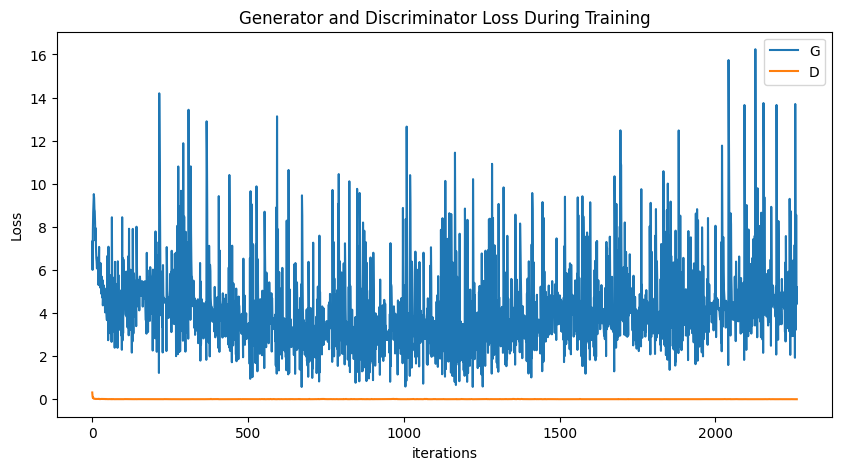

In [11]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Plot Random Generated Inputs

In [12]:
# # load best model
# netG.load_state_dict(torch.load(opts.model_out / 'G.pth'))

In [13]:
# lines = []

# # generate random samples
# for i in range(100):
#     noise = torch.randn_like(real, device=device)
#     fake, _ = netG(noise)
#     fake = fake.flatten(end_dim=1).detach().cpu().numpy()
#     lines.append(fake)


# inv_fake_data = dataset.unscale(np.array(lines))
# # inv_fake_data = pd.DataFrame(inv_fake_data)

In [14]:
# plot_data_values(inv_fake_data, "Random Generated", label="B [G]", scale="log")

# Anomaly Detection

In [15]:
# load best models
netG.load_state_dict(torch.load(opts.model_out / 'Gbest.pth'))
netD.load_state_dict(torch.load(opts.model_out / 'Dbest.pth'))

netD.train(True)
netG.train(True)
# netG.train = False
# netD.train = False

class AnomalyParams:
    batch_size = 128
    # reconstruction based
    niter = 80 # number of iterations for reconstruction
    lambda_thresh = 0.1
    lr = 1e-2
    
    
opts_eval = AnomalyParams()
eval_dataset = MULTI_VP_Dataset(opts.data_path, method=opts.method, scaler=opts.scaler, window_size=10,)
eval_dataloader = DataLoader(eval_dataset, batch_size=opts_eval.batch_size, shuffle=False, num_workers=opts.nworkers)

Window size: 10
Window shape:  torch.Size([10, 640])
First window:
 tensor([[0.4708, 0.4708, 0.4708,  ..., 1.7176, 1.7176, 1.7176],
        [0.4932, 0.4931, 0.4931,  ..., 1.7176, 1.7176, 1.7176],
        [0.5494, 0.5494, 0.5493,  ..., 1.7176, 1.7176, 1.7176],
        ...,
        [0.4831, 0.4831, 0.4831,  ..., 1.7176, 1.7176, 1.7176],
        [0.4863, 0.4863, 0.4862,  ..., 1.7176, 1.7176, 1.7176],
        [0.5500, 0.5499, 0.5498,  ..., 1.7176, 1.7176, 1.7176]])
Inputs shape: (11771, 640)
Inputs head:
 [[0.47077032 0.47077768 0.4707572  ... 1.7175509  1.7175508  1.71755066]
 [0.49316897 0.49314775 0.49309755 ... 1.71760377 1.7175984  1.7175935 ]
 [0.54943652 0.54937473 0.54928123 ... 1.71761199 1.71760579 1.71760015]
 [0.45546222 0.45543926 0.45538911 ... 1.717627   1.7176193  1.71761231]
 [0.52823626 0.52814208 0.52801717 ... 1.7176049  1.71759941 1.71759441]]


## Discriminator Classification

In [16]:
scores = []
# calculate classification scores for each sample
for i , (x, filenames) in enumerate(eval_dataloader):
    outputs = netD(x.to(device))
    # calculate mean classification score for each sample
    for sample, filename in zip(outputs, filenames):
        # print(sample, filename)
        class_avg = sample[0]
        scores.append((filename, 1-class_avg.item()))

Found 33 anomalies


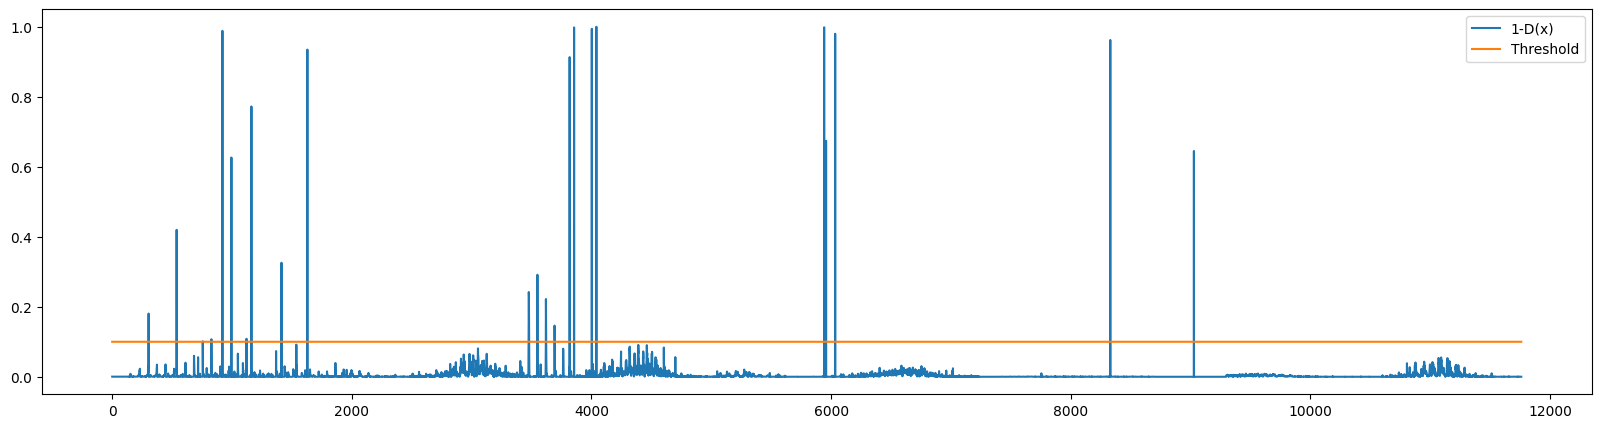

In [46]:
discr_thresh = 0.1
anomalies = [score[0] for score in scores if score[1] > discr_thresh]
print(f"Found {len(anomalies)} anomalies")

scores_fig, ax = plt.subplots(figsize=(20, 5))
ax.plot([score[1] for score in scores], label='1-D(x)')
ax.plot(discr_thresh*np.ones(len(scores)), label='Threshold')
plt.legend()
_ = plot_to_tensorboard(logger, scores_fig, 0, "test/discr")

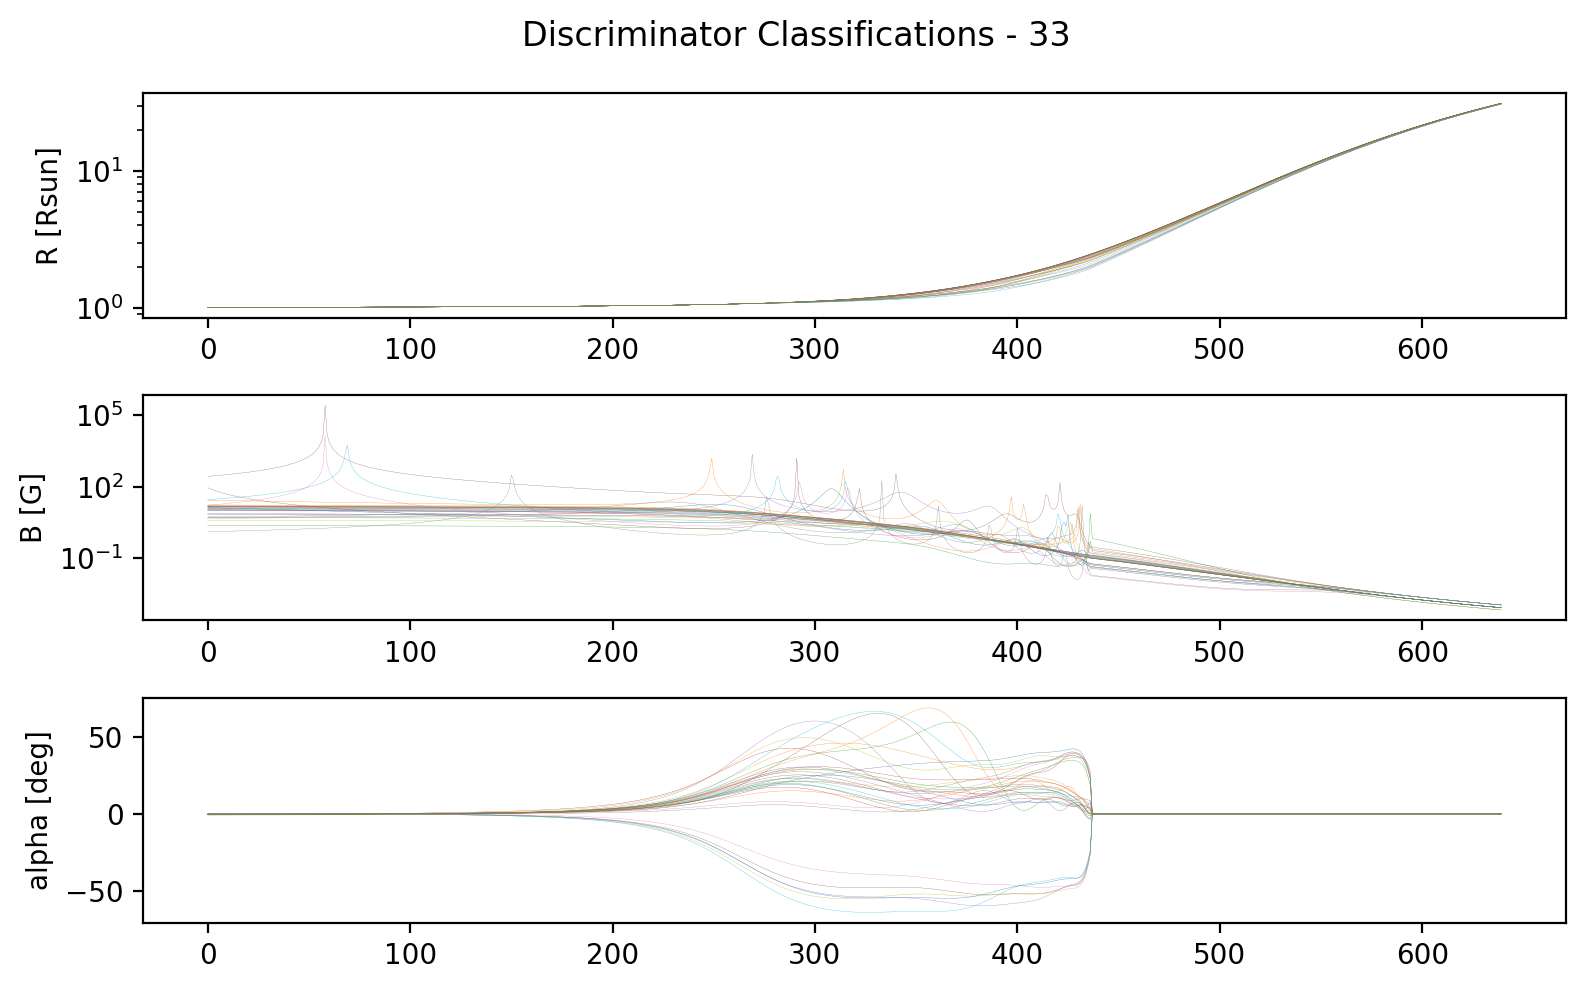

In [47]:
anomal_fig = plot_anomalies(anomalies, opts.data_path, f"Discriminator Classifications - {len(anomalies)}", figsize=(8, 5), dpi=200)
_ = plot_to_tensorboard(logger, anomal_fig, 0, "test/discr_anomalies")

## Reconstruction Based

In [37]:
def reconstruction_anomaly_scores(dataloader, netG : nn.Module, netD : nn.Module, device : str,
                                  max_iters=100, reconstr_fn=madgan_reconstruction):
    mse_scores = []
    for i, (x, filenames) in enumerate(dataloader, 0):
        _z, loss = reconstr_fn(x, netG, netD, device, max_iters)
        mse_scores.extend(zip(filenames, [l.sum().detach().cpu().numpy() for l in loss]))
        print(f"[{i}/{len(dataloader)}]", end='\r', flush=True)
        
    return mse_scores

In [38]:
reconstr_scores = reconstruction_anomaly_scores(eval_dataloader, netG, netD, device, 100, madgan_reconstruction)

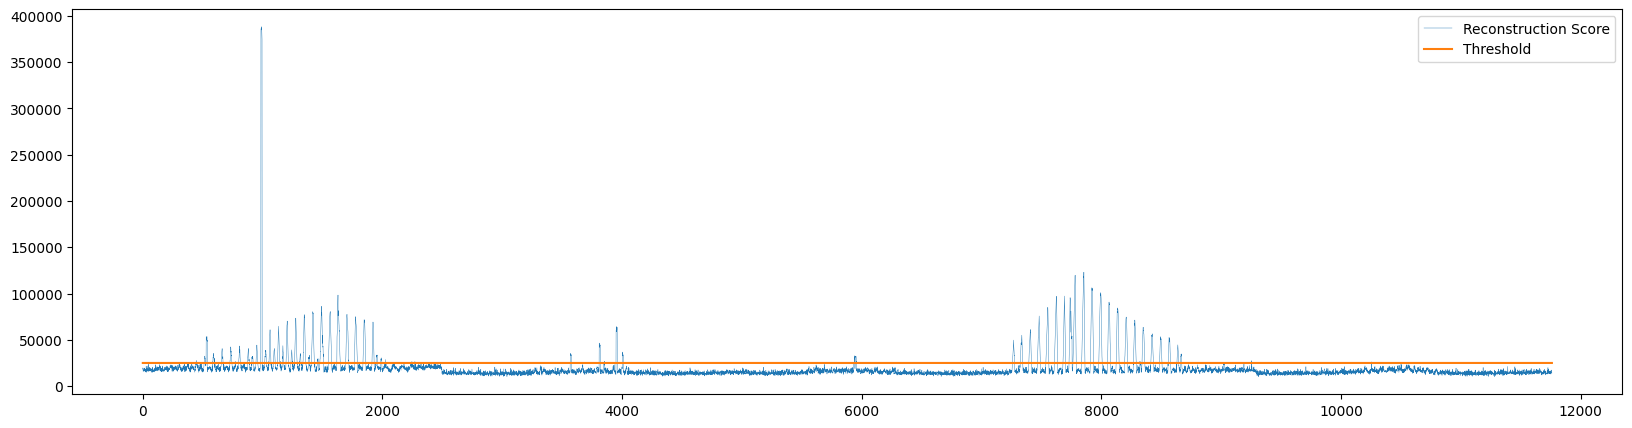

In [40]:
reconstr_score_thresh = 25000
scores_fig, ax = plt.subplots(figsize=(20, 5))
ax.plot([score[1] for score in reconstr_scores], label='Reconstruction Score', linewidth=0.3)
ax.plot(reconstr_score_thresh*np.ones(len(reconstr_scores)), label='Threshold')
plt.legend()
_ = plot_to_tensorboard(logger, scores_fig, 0, "test/mse")

Found 1138 anomalies


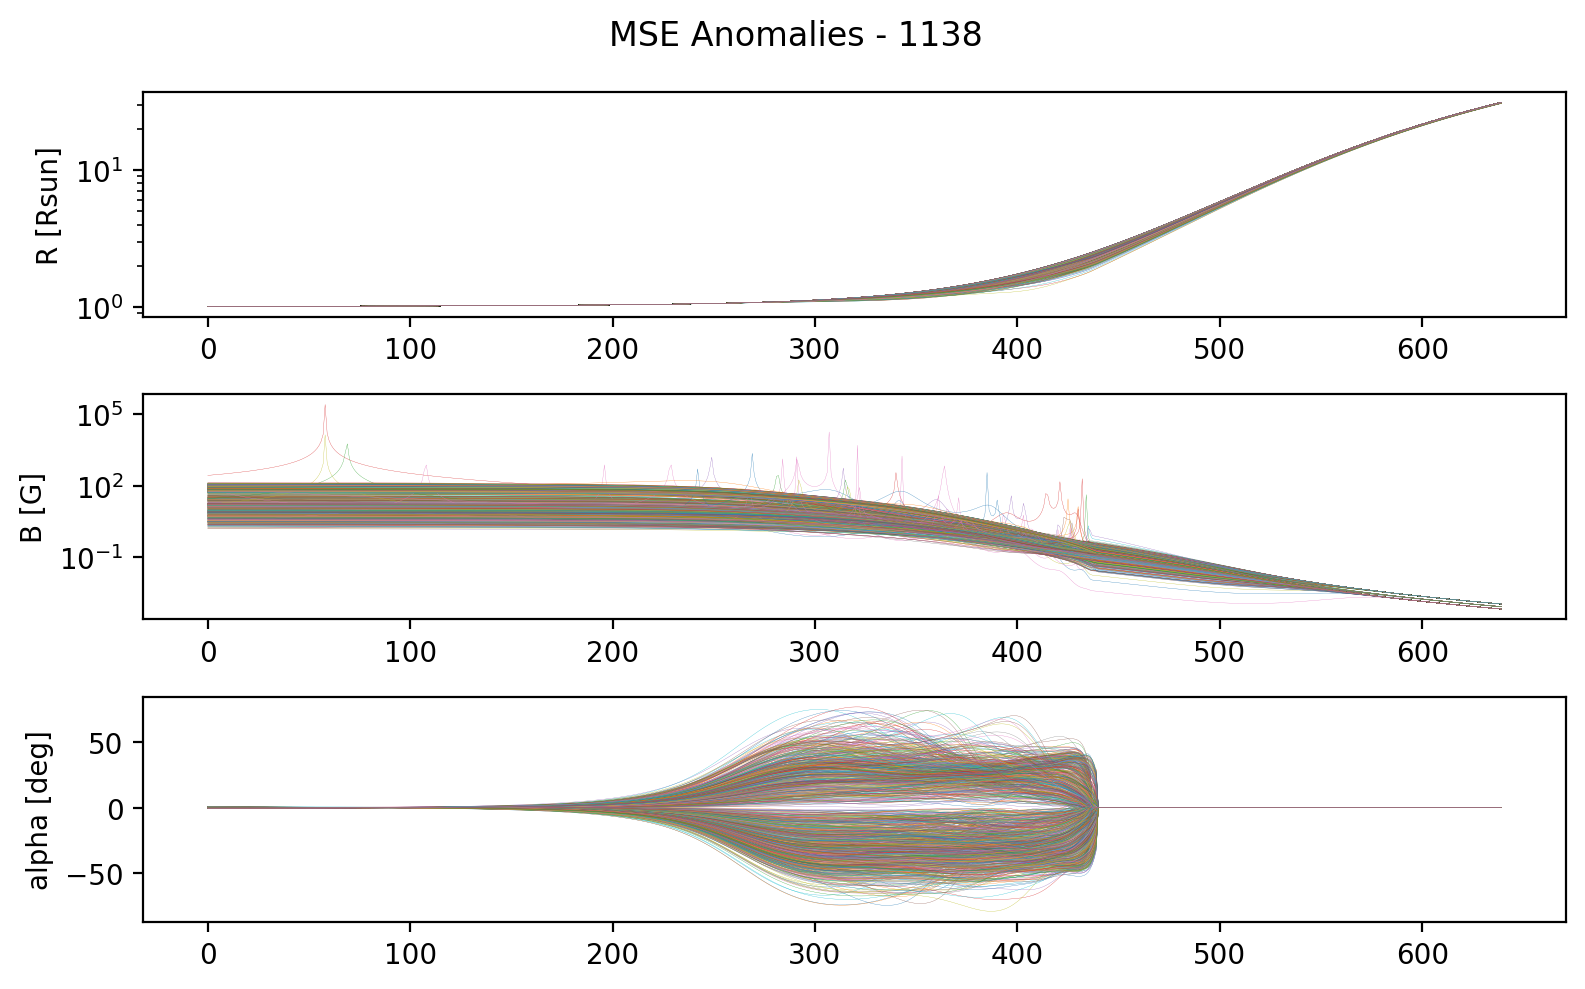

In [41]:
anomalies = [score[0] for score in reconstr_scores if score[1] > reconstr_score_thresh]
print(f"Found {len(anomalies)} anomalies")
anomal_fig = plot_anomalies(anomalies, opts.data_path, f"MSE Anomalies - {len(anomalies)}", figsize=(8, 5), dpi=200)
_ = plot_to_tensorboard(logger, anomal_fig, 0, "test/mse_anomalies")

### Reconstruction with discriminator feedback

In [23]:
reconstr_scores_discr = reconstruction_anomaly_scores(eval_dataloader, netG, netD, device, 100, madgan_reconstruction_discr_loss)

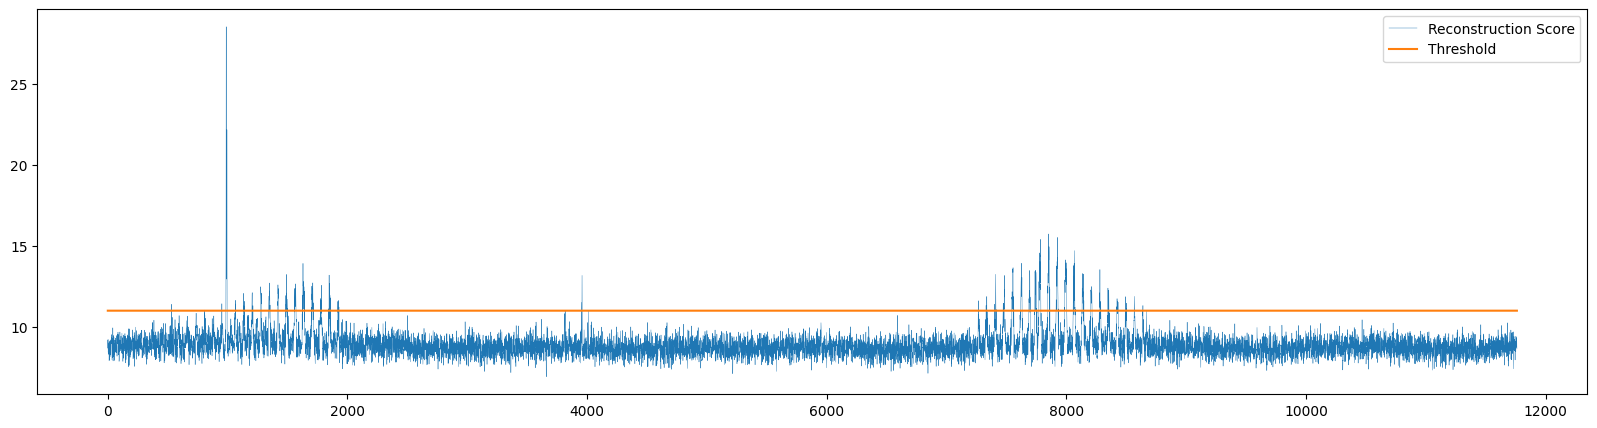

In [30]:
reconstr_score_thresh = 11
scores_fig, ax = plt.subplots(figsize=(20, 5))
ax.plot([score[1] for score in reconstr_scores_discr], label='Reconstruction Score', linewidth=0.3)
ax.plot(reconstr_score_thresh*np.ones(len(reconstr_scores_discr)), label='Threshold')
plt.legend()
_ = plot_to_tensorboard(logger, scores_fig, 0, "test/mse")

Found 365 anomalies


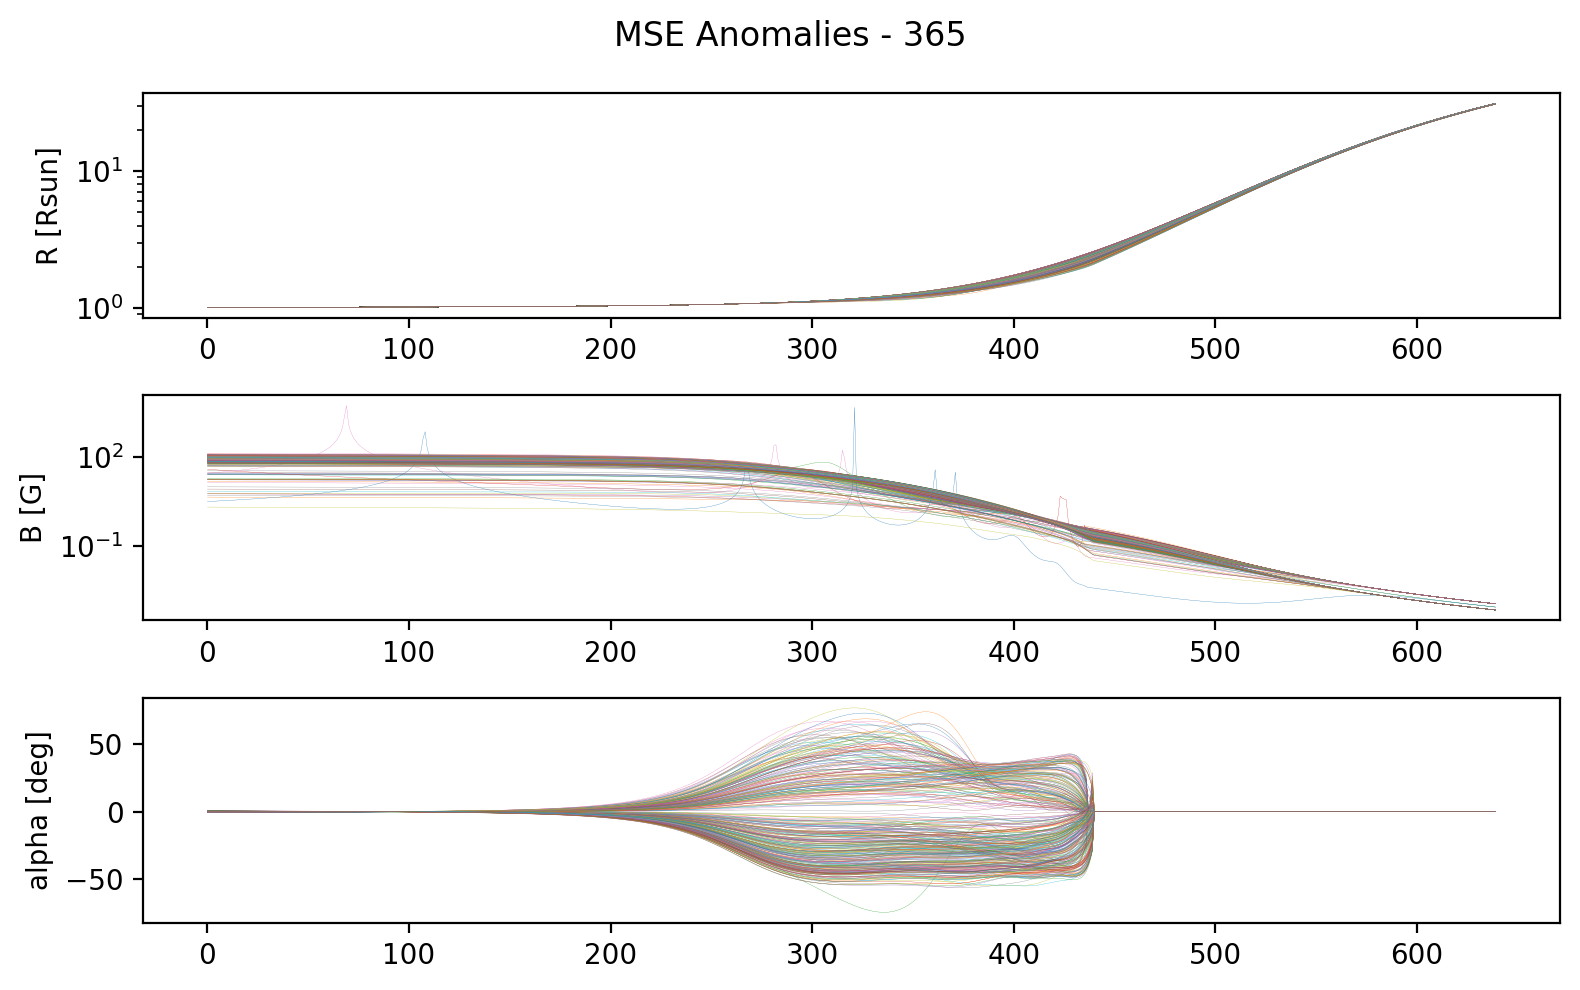

In [31]:
anomalies = [score[0] for score in reconstr_scores_discr if score[1] > reconstr_score_thresh]
print(f"Found {len(anomalies)} anomalies")
anomal_fig = plot_anomalies(anomalies, opts.data_path, f"MSE Anomalies - {len(anomalies)}", figsize=(8, 5), dpi=200)
_ = plot_to_tensorboard(logger, anomal_fig, 0, "test/mse_anomalies")

In [26]:
logger.flush()